In [37]:
import pandas as pd
import random
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
import seaborn as sns
from scipy.stats import norm
import scipy.optimize as sco
import datetime

In [38]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [39]:
stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]

In [40]:
tickers=stocks['Ticker'].to_list()

In [41]:
data=get_close(tickers,"2023-01-01")
data=data.dropna()
n=len(data.columns)

FLTR.IR: No data found, symbol may be delisted


In [42]:
returns=np.log(1+data.pct_change())

# Portfolio Construction

In [43]:
def halton_sequences(number,base=2):
    
    inv_base=1/base
    
    i=number
    halton=0
    
    while i>0:
        
        digit = i%base
        halton=halton + digit*inv_base
        i=(i-digit)/base
        inv_base=inv_base/base
        
    return halton

def generate_halton(iterations,dimensions=1,base=2):
    
    rng = np.random.default_rng()
    matrix=[]
    haltons=[]
    
    for i in range(iterations):
        halton=halton_sequences(i,base=base)
        haltons.append(halton)
    
    for dim in range(dimensions):
        
        matrix.append(haltons)
    
    matrix = rng.permuted(matrix, axis=1)
    return matrix

def near_psd(x, epsilon=0):

    if min(np.linalg.eigvals(x)) > epsilon:
        return x

    n = x.shape[0]
    var_list = np.array(np.sqrt(np.diag(x)))
    y = np.array([[x[i, j]/(var_list[i]*var_list[j]) for i in xrange(n)] for j in xrange(n)])

    eigval, eigvec = np.linalg.eig(y)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec, vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    near_corr = B*B.T    

    near_cov = np.array([[near_corr[i, j]*(var_list[i]*var_list[j]) for i in xrange(n)] for j in xrange(n)])
    return near_cov

def performance(perf,weights):
    
    return np.dot(perf,weights)


In [44]:
class Portfolio:
    
    def __init__(self,data,start_date=min(data.index),end_date=max(data.index)):
        
        self.data=data.loc[start_date:end_date]

    def portfolio(self,weights):
            
        portfolio=pd.DataFrame()
        portfolio['Portfolio']=np.sum(weights*returns,axis=1)
        
        return portfolio
    
    def evolution(self,weights):
        
        portfolio=self.portfolio(weights)
        evolution=(1+portfolio).cumprod()*100
        
        return evolution
    
    def performance(self,weights):
        performance=np.sum(self.data*weights).mean()*252
        return performance
    
    def variance(self,weights):
        variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
        return variance
    
    def sharpe_ratio(weights):
            return self.performance(weights)/self.variance(weights)

    def optimize(self,objective='minimum_variance',constraints=False):
        
            
        def sum_equal_one(weight):
            return np.sum(weight) - 1   
        
        def sharpe_ratio(weights):
            return - self.performance(weights)/self.variance(weights)
        
        def variance(weights):
            variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
            return variance
        
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        
        if not constraints:
            
            constraints = [{'type': 'eq', 'fun': sum_equal_one}]
        
        else:
            
            constraints=[{'type': 'eq', 'fun': sum_equal_one}]+constraints
        
        if objective=='minimum_variance':

            optimum_weights = sco.minimize(variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        elif objective=='sharpe_ratio':
            
            optimum_weights = sco.minimize(sharpe_ratio, weight, method='SLSQP', bounds=bounds, constraints=constraints)
            
        else:
            
            print("Objective function undefined")
            
            
        return optimum_weights.x
    
    def black_Litterman(self,P,Q,weights,risk_aversion,tau=0.025):
        
        implied_returns=risk_aversion*self.data.cov().dot(weights).squeeze()
        omega=np.diag(np.diag(P.dot(tau*self.data.cov()).dot(P.T)))
        sigma_scaled=self.data.cov()*tau
        BL_returns= implied_returns + sigma_scaled.dot(P.T).dot(np.linalg.inv(P.dot(sigma_scaled).dot(P.T))+omega).dot(Q-P.dot(implied_returns))
        inv_cov=np.linalg.inv(self.data.cov())
        BL_weights=inv_cov.dot(BL_returns)
        BL_weights=BL_weights/BL_weights.sum()
        
        return BL_weights,BL_returns

## Risk Analysis

In [140]:
class RiskAnalysis(Portfolio):
    
    def __init__(self,returns,start_date=min(returns.index),end_date=max(returns.index)):
        
        self.returns=returns.loc[start_date:end_date]
        super().__init__(data=self.returns)
        

    def historical_var(self,weights,last_days=False,Q=5):

        performance=super().portfolio(weights)
        
        if last_days:
            performance=performance[-last_days:]
            
        var=np.percentile(performance,Q)
        cvar=performance[performance<var].mean().values[0]
        
        return var,cvar
    
    
    def parametric_var(self,weights,Q=0.95):
        
        intervals=np.arange(Q, 1, 0.0005, dtype=float)
        
        variance=super().variance(weights)
        VaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-Q)
        CVaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-intervals).mean()
        
        return VaR,CVaR
        
        
    def multivariate_distribution(self,
                    stress_factor=1.0,
                    iterations=10000):
        
        num_asset=len(self.returns.columns)
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else:       
            stress_vec=stress_factor
            
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        mean=self.returns.mean()
        
        multivariate=np.random.multivariate_normal(mean,stressed_cov,iterations)
        
        
        return multivariate
    
    
    def rolling_var(self,weights,window=30,Q=1):
        
        value_at_risk=pd.DataFrame()
        
        mean=returns.rolling(window).mean().dropna()
        cov=returns.rolling(window).cov().dropna()

        index=tuple(set(cov.index.get_level_values(0)))


        var={}

        for date in index:

            multivariate_var=performance(np.random.multivariate_normal(mean.loc[date],cov.loc[date],10000),weights)
            var[date]=np.percentile(multivariate_var,Q)

        multivariate_var=pd.DataFrame(var.values(),index=var.keys())
        
        portfolio=super().portfolio(weights)
        
        value_at_risk['Historical']=portfolio.rolling(window=window).apply(lambda x:np.percentile(x,Q))
        value_at_risk['Parametric']=portfolio.rolling(window=window).std()*norm(loc =0 , scale = 1).ppf(Q/100)
        value_at_risk['Multivariate']=multivariate_var
        value_at_risk['Portfolio']=portfolio
        
        return value_at_risk

    def pca(self,num_components=2):
        
        cov_matrix=self.returns.cov()
        
        cov_matrix=returns.cov()
        
        eig_val, eig_vec=np.linalg.eig(cov_matrix)
        sorted_eig_val=eig_val.argsort()[::-1]
        eig_val=eig_val[sorted_eig_val]
        eig_vec=eig_vec[:,sorted_eig_val]
        eig_val=eig_val[:num_components]
        eig_vec=eig_vec[:,0:num_components]
        
        PC={}
        
        for i in range(eig_vec.shape[1]):
            
            PC["PC" +str(i+1)]=eigvec[:,i]/eigvec[:,i].sum()
        
        portfolio_components=pd.DataFrame(PC.values(),index=PC.keys(),columns=data.columns).T
        
        return eig_val,eig_vec,portfolio_components
                
    
    def monte_carlo(self,spot,horizon=20/250,iterations=100000,stress_factor=1.0):
        
        
        
        num_asset=len(self.returns.columns)
        #haltons=generate_halton(iterations,num_asset,base=2)
        randoms=np.random.normal(size=(10000,num_asset)).T
        
        #cree une matrice de stress pour envoyer des shock sur les corrélations
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else: 
            
            stress_vec=stress_factor
        
        # Multiplication des volatilités par un facteur de stress
        
        vol=self.returns.std()*np.sqrt(250)*stress_vec
        
        # Cree une matrice diagonale de facteurs de stress pour perturber la matrice de covariance
        
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        
        # trouve la matrice de covariance semie definie positive 
        # la plus proche apres avoir appliquée les choque a la matrice de covariance
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        stressed_std=np.sqrt(np.diag(stressed_cov))
        corr_matrix=stressed_cov/np.outer(stressed_std,stressed_std)
        sdp_corr_matrix=near_psd(corr_matrix)
        
        #calcule la decomposition de Cholesky 
        cholesky=np.linalg.cholesky(corr_matrix)
            
        drift=np.exp(-0.5*horizon*vol**2)
        factors=spot*drift
        factors_vec=factors.to_numpy().reshape(num_asset,-1)
                
        simulation=np.matmul(cholesky,randoms).T
        simulation=pd.DataFrame(simulation)
        simulation.columns=self.returns.columns
 
        
        monte_carlo=factors_vec.T*np.exp(simulation.dot(np.diag(vol))*np.sqrt(horizon))
        monte_carlo=pd.DataFrame(monte_carlo)
        monte_carlo.columns=self.returns.columns
        perf_monte_carlo=np.log(monte_carlo/spot)
        
        return monte_carlo,perf_monte_carlo
    
    
    

In [141]:
test=RiskAnalysis(returns)

In [142]:
num_asset=len(data.columns)
weights=np.random.rand(num_asset)
weights=weights/weights.sum()

In [143]:
weights=test.optimize(objective="minimum_variance",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.1 - weights}])
weights=np.round(weights,2)

In [144]:
var,cvar=test.historical_var(weights,last_days=30)
var,cvar

(-0.0030795427057525976, -0.003725018739870684)

In [145]:
var,cvar=test.parametric_var(weights)
var,cvar

(-0.009389295177442884, -0.012034480421139967)

In [146]:
perf=performance(test.multivariate_distribution(),weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.008686119694853743, -0.011242229216623555)

In [147]:
spot=data.iloc[-1]
monte_carlo=test.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.009592871359972744, -0.01210352733360907)

In [148]:
stuf=test.rolling_var(weights,window=30,Q=1).dropna()

In [149]:
stuf['Overshoot']=np.where(stuf['Portfolio']<stuf['Historical'],1,0)

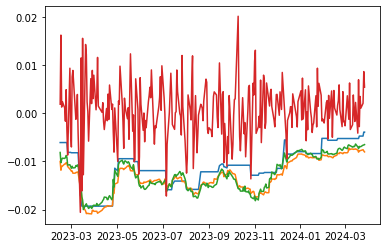

In [150]:
plt.plot(stuf[['Historical','Parametric','Multivariate','Portfolio']])

In [151]:
stuf.iloc[np.where(stuf['Overshoot']==1)]

,Historical,Parametric,Multivariate,Portfolio,Overshoot
2023-02-24,-0.008109,-0.011043,-0.010746,-0.008674,1
2023-03-13,-0.017126,-0.015473,-0.014516,-0.020578,1
2023-05-24,-0.010023,-0.011730,-0.012019,-0.010041,1
2023-05-30,-0.011899,-0.013749,-0.014450,-0.012658,1
2023-07-06,-0.015874,-0.015556,-0.016292,-0.017187,1
2023-10-27,-0.012858,-0.016654,-0.017393,-0.013619,1
2023-12-14,-0.008456,-0.011492,-0.010107,-0.009431,1


In [173]:
eigval,eigvec,portfolio_components=test.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.555422  , 0.21576648, 0.10276708, 0.06874698, 0.05729746])

In [172]:
portfolio_components

,PC1,PC2,PC3,PC4,PC5
ADS.DE,0.030275,0.035250,-19.009586,0.059120,-0.021997
ADYEN.AS,0.062409,-0.497636,23.373967,0.012600,1.118571
AD.AS,0.004503,0.002959,0.488682,0.116733,0.115916
AI.PA,0.013844,0.027292,0.295504,0.112061,-0.443498
AIR.PA,0.016685,0.038450,6.118217,0.017928,-0.726609
ALV.DE,0.015529,0.048736,6.785421,0.060767,-0.136139
ABI.BR,0.010939,0.027037,-1.486215,0.101863,0.460665
ASML.AS,0.026301,-0.019300,-20.016505,-0.127090,-1.733594
CS.PA,0.019547,0.068956,11.223282,0.030653,-0.038691
BAS.DE,0.025162,0.041671,-4.413462,0.007688,1.462692


<AxesSubplot:>

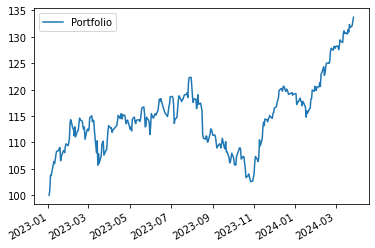

In [118]:
test.evolution(PC["PC1"]).plot()

<AxesSubplot:>

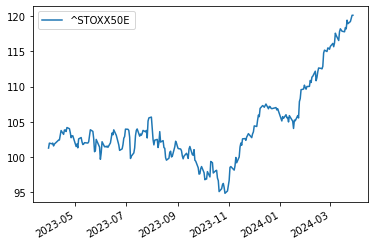

In [119]:
((1+get_close(['^STOXX50E']).pct_change()).cumprod()*100).plot()